# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## MNIST Dataset


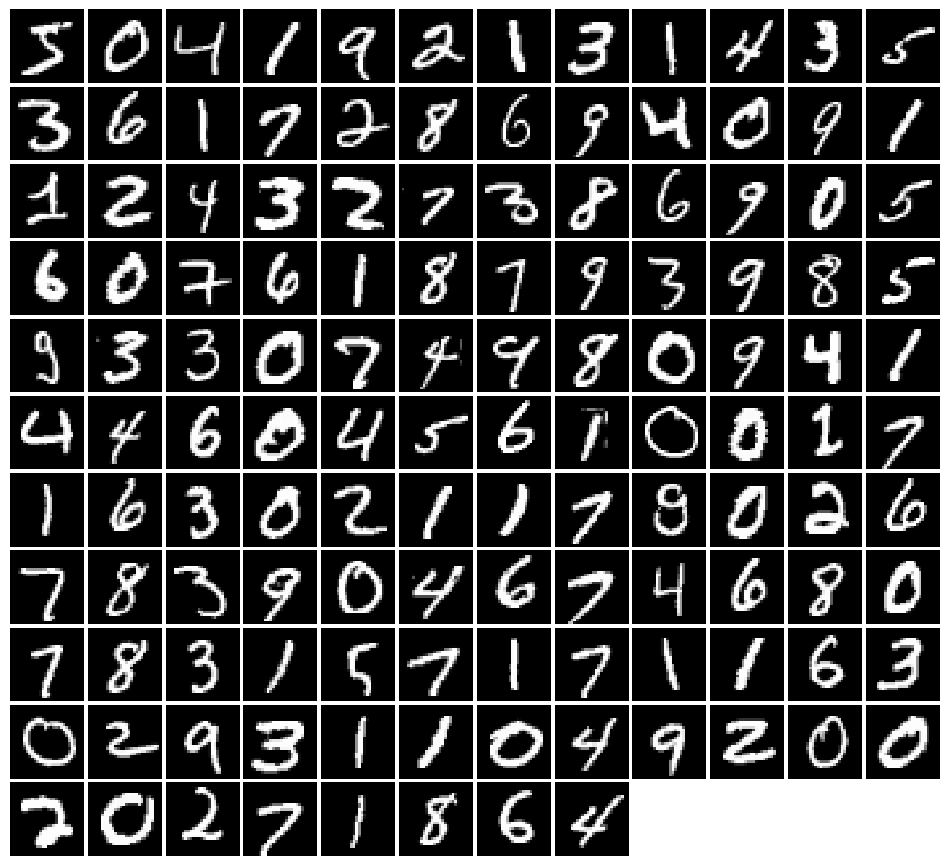

In [6]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = next(iter(loader_train))[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [25]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [26]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [27]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 1.407, G:0.7269


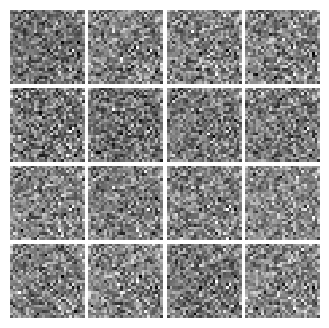


Iter: 250, D: 0.9923, G:1.847


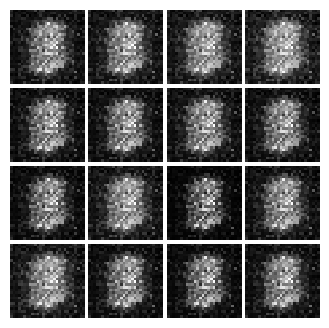


EPOCH:  2
Iter: 500, D: 1.038, G:1.195


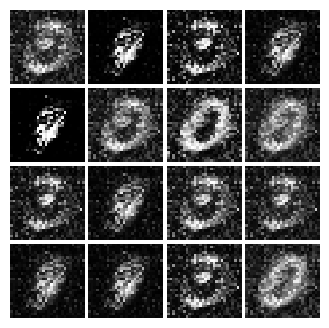


Iter: 750, D: 1.28, G:3.896


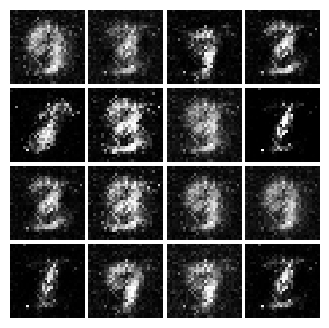


EPOCH:  3
Iter: 1000, D: 1.156, G:1.2


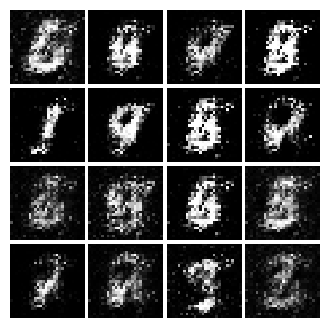


Iter: 1250, D: 1.237, G:0.9167


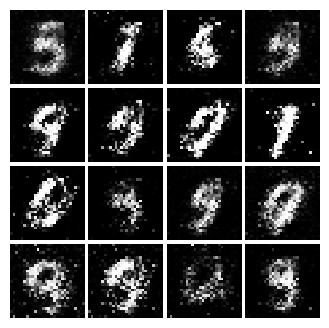


EPOCH:  4
Iter: 1500, D: 1.135, G:1.153


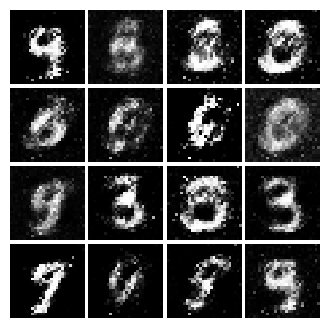


Iter: 1750, D: 1.158, G:1.062


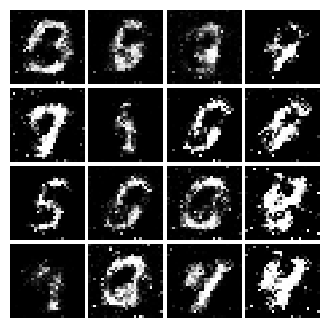


EPOCH:  5
Iter: 2000, D: 1.191, G:0.8335


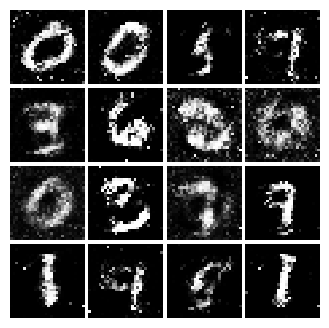


Iter: 2250, D: 1.232, G:0.787


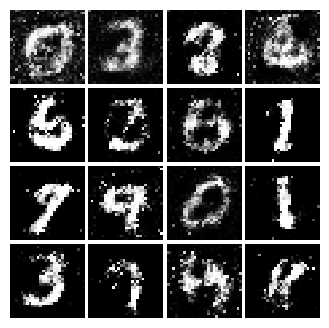


EPOCH:  6
Iter: 2500, D: 1.273, G:1.099


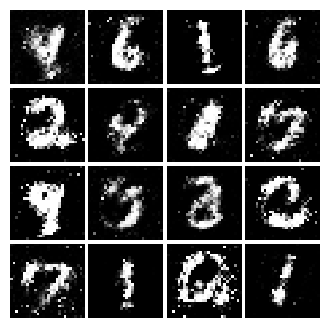


Iter: 2750, D: 1.294, G:1.159


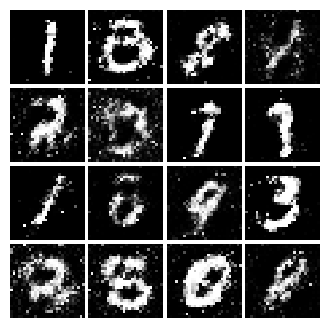


EPOCH:  7
Iter: 3000, D: 1.304, G:0.7969


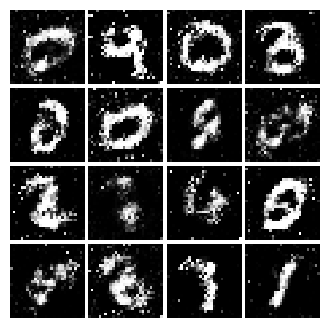


Iter: 3250, D: 1.231, G:0.9077


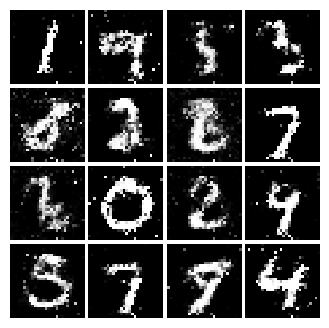


EPOCH:  8
Iter: 3500, D: 1.295, G:0.9387


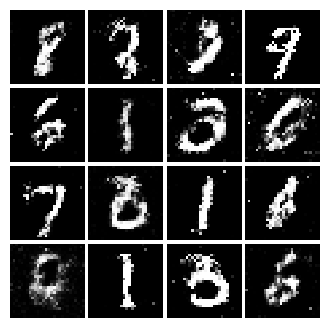


EPOCH:  9
Iter: 3750, D: 1.258, G:0.8266


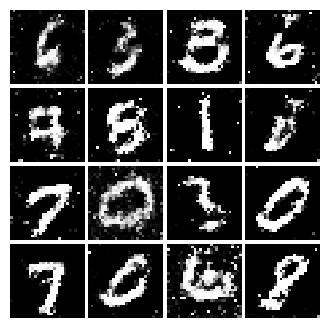


Iter: 4000, D: 1.434, G:0.8087


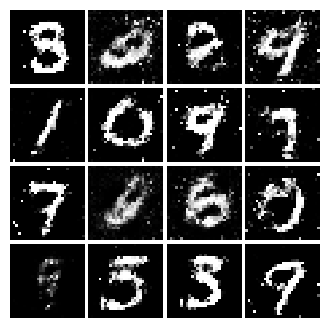


EPOCH:  10
Iter: 4250, D: 1.294, G:0.8326


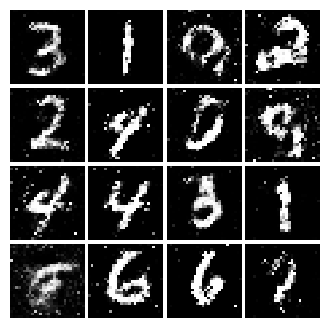


Iter: 4500, D: 1.321, G:0.8374


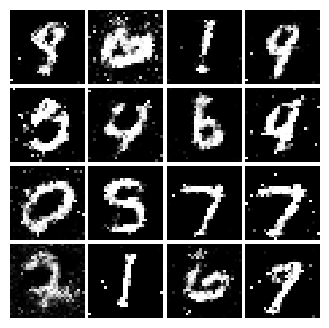

In [28]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1
Iter: 0, D: 0.3625, G:0.4205


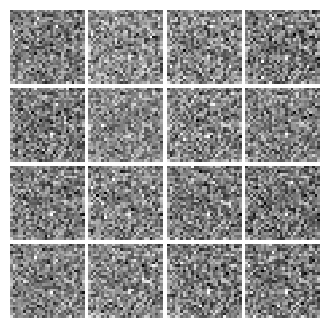


Iter: 250, D: 0.1152, G:0.3872


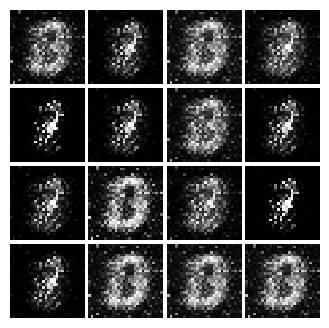


EPOCH:  2
Iter: 500, D: 0.1777, G:0.09482


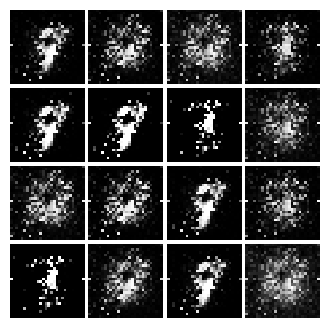


Iter: 750, D: 0.162, G:0.7239


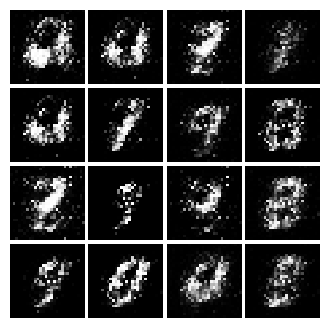


EPOCH:  3
Iter: 1000, D: 0.1977, G:0.2887


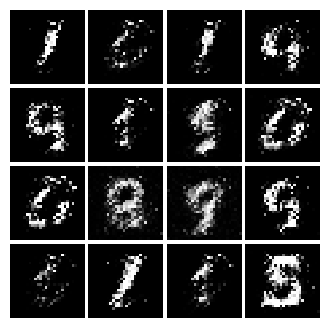


Iter: 1250, D: 0.1956, G:0.1928


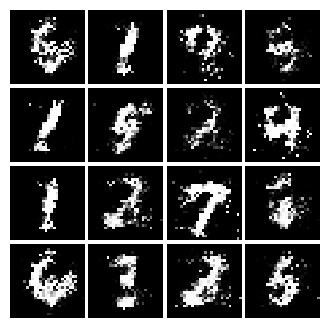


EPOCH:  4
Iter: 1500, D: 0.1855, G:0.2882


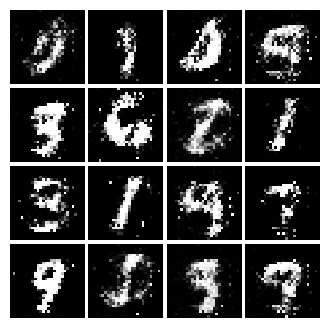


Iter: 1750, D: 0.1949, G:0.1863


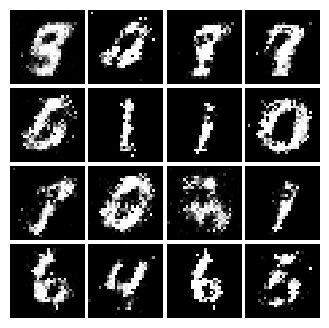


EPOCH:  5
Iter: 2000, D: 0.1772, G:0.1782


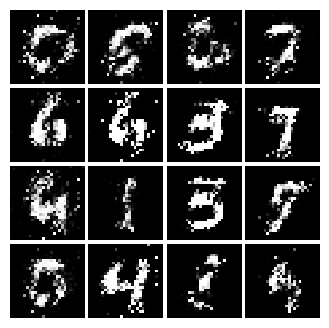


Iter: 2250, D: 0.2159, G:0.1714


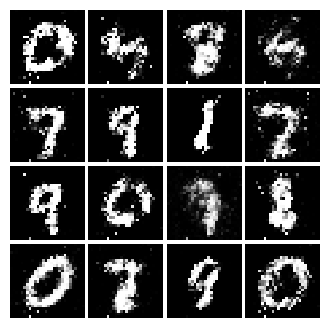


EPOCH:  6
Iter: 2500, D: 0.1975, G:0.1833


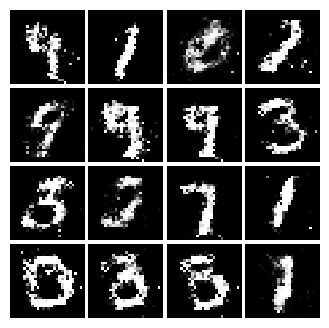


Iter: 2750, D: 0.237, G:0.1695


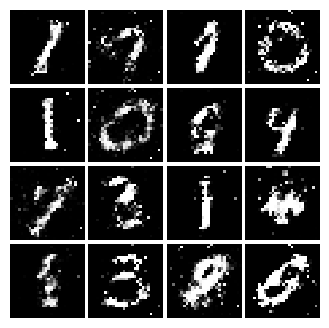


EPOCH:  7
Iter: 3000, D: 0.2353, G:0.1757


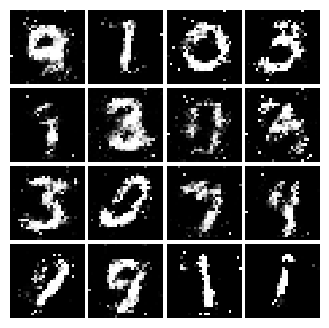


Iter: 3250, D: 0.2351, G:0.189


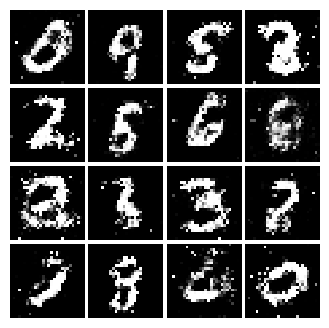


EPOCH:  8
Iter: 3500, D: 0.2287, G:0.1718


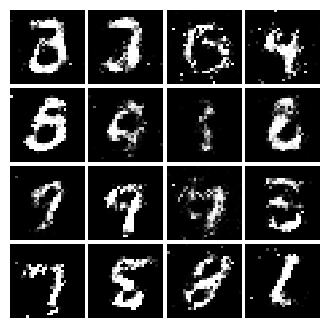


EPOCH:  9
Iter: 3750, D: 0.2211, G:0.1621


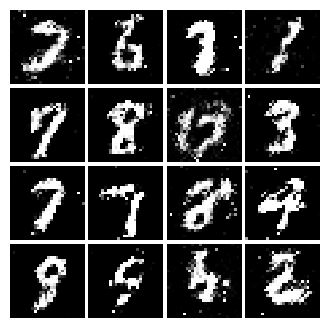


Iter: 4000, D: 0.2424, G:0.134


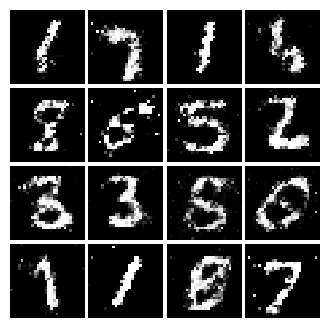


EPOCH:  10
Iter: 4250, D: 0.22, G:0.2057


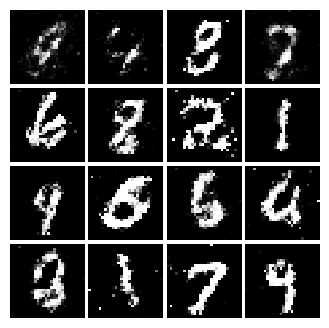


Iter: 4500, D: 0.2298, G:0.1546


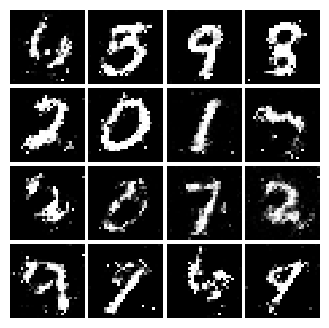

In [29]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)